In [1]:
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch

In [12]:
import numpy as np
from skimage.draw import polygon2mask
from torchvision import io
from kornia import augmentation as aug
from torchvision.transforms.v2 import ToDtype

res = 37

augmentation = aug.container.AugmentationSequential(
    ToDtype(torch.float32, scale=True),
    aug.RandomGrayscale(p=1.0),
)

images_root = "dataset/images"
annos_root = "dataset/annos"
images, labels = [], []
for fname in os.listdir(images_root):
    image = io.read_image(os.path.join(images_root, fname))
    images.append(image)
    anno = np.load(os.path.join(annos_root, fname.removesuffix(".jpg") + ".npy"))
    anno = polygon2mask(image.shape[1:], anno[:, ::-1])
    labels.append(anno)
images = torch.stack(images)
images = augmentation(images)
labels = torch.stack([torch.from_numpy(l) for l in labels])

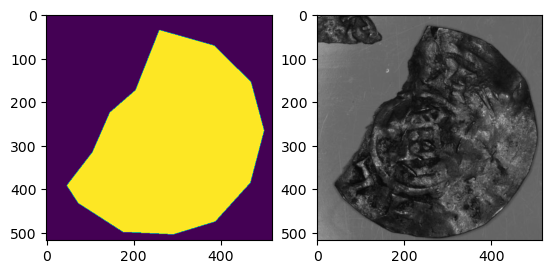

In [13]:
import matplotlib.pyplot as plt

fig, (a1, a2) = plt.subplots(1, 2)
a1.imshow(labels[0])
a2.imshow(images[0].permute(1, 2, 0))

In [14]:
device = torch.device("mps")
dino = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14_reg").to(device)

with torch.no_grad():
    tokens = dino.forward_features(images.to(device))
    patch_tokens = tokens["x_norm_patchtokens"].cpu()

Using cache found in /Users/jatentaki/.cache/torch/hub/facebookresearch_dinov2_main
/Users/jatentaki/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/jatentaki/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/jatentaki/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [19]:
from einops import rearrange

x = rearrange(patch_tokens, "b (h w) c -> b h w c", h=res, w=res).to(device)
y = (
    (
        rearrange(labels, "b (h i) (w j) -> b h w (i j)", h=res, w=res).float().mean(-1)
        > 0.5
    )
    .float()
    .to(device)
)

In [24]:
linear = torch.nn.Linear(384, 1).to(device)
optim = torch.optim.Adam(linear.parameters(), lr=1e-4)

for i in range(1_000):
    y_hat = linear(x).squeeze(-1)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(y_hat, y)
    optim.zero_grad()
    loss.backward()
    if i % 100 == 99:
        print(loss.item())
    optim.step()

0.3958796560764313
0.25724896788597107
0.1893177330493927
0.15049274265766144
0.12585517764091492
0.10903241485357285
0.09691204875707626
0.08781559765338898
0.08076649904251099
0.07516150176525116


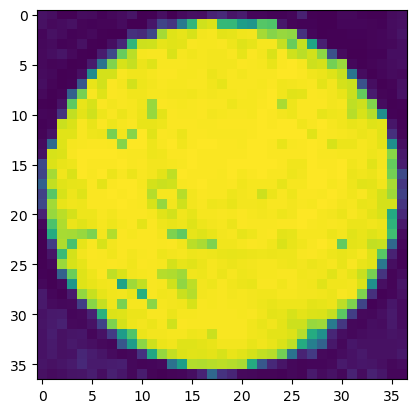

In [27]:
plt.imshow(y_hat.detach().sigmoid()[1].cpu())

In [28]:
torch.save(linear.state_dict(), "coin_fg_bf_classifier.pt")